In [17]:
import numpy as np
import wfdatabase/train
import matplotlib.pyplot as plt
import os

In [18]:
def get_file(path="database/train/drive01", sampfrom=0, n_samp=500, do_sample=True, skip_no_emg=False):
    dir_name, record_name = os.path.split(path)
    hea_path = os.path.join(dir_name, f"{record_name}.hea")

    emg_line_found = False
    if os.path.isfile(hea_path):
        with open(hea_path, 'r') as f:
            for line in f:
                if 'EMG' in line:
                    emg_line_found = True
                    break
    
    if skip_no_emg and not emg_line_found:
        return None, None
    
    if not emg_line_found:
        raise Exception(f"File {path} does not contain EMG data")

    if do_sample:
        sig, sinfo = wfdatabase/train.rdsamp(path, sampfrom=sampfrom, sampto=sampfrom + n_samp)
    else:
        sig, sinfo = wfdatabase/train.rdsamp(path)
    sig = sig[:, 1].flatten()

    sinfo["record_name"] = os.path.basename(path)

    sinfo["contains_emg"] = emg_line_found

    annotation_path = os.path.join(dir_name, f"{record_name}.atr")
    if os.path.isfile(annotation_path):
        if do_sample:
            ann = wfdatabase/train.rdann(path, extension='atr', sampfrom=sampfrom, sampto=sampfrom + n_samp)
        else:
            ann = wfdatabase/train.rdann(path, extension='atr')
        sinfo['annotation'] = ann
    else:
        sinfo['annotation'] = None

    return sig, sinfo

def load_train_data(folder="database/train", sampfrom=0, n_samp=500, do_sample=True, skip_no_emg=False):
    signals = []
    info = []

    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)

        if os.path.isfile(file_path) and file_name.startswith("drive") and file_name.endswith(".dat"):
            file_without_extension = os.path.splitext(file_name)[0]
            new_file_name = f"{folder}/{file_without_extension}"
            sig, sinfo = get_file(new_file_name, sampfrom=sampfrom, n_samp=n_samp, do_sample=do_sample, skip_no_emg=skip_no_emg)
        
            if sig is None:
                continue

            signals.append(sig)
            info.append(sinfo)

    return signals, info

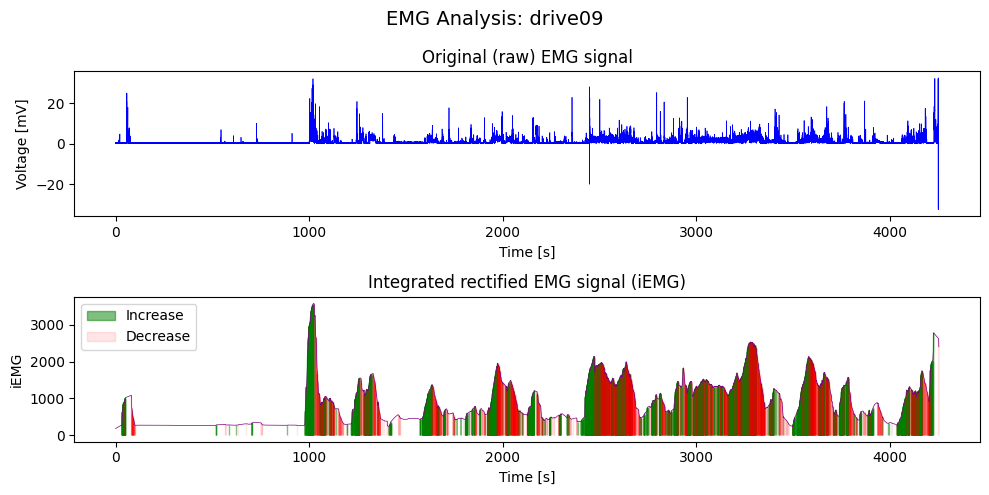

In [19]:
signal, sinfo = get_file("database/train/drive09", do_sample=False)
threshold = 1.5

rectified_signal = np.abs(signal)
time = np.arange(len(signal)) / sinfo["fs"]

integrated_signal = np.convolve(rectified_signal, np.ones(int(sinfo["fs"])*50), mode="same")
derivative = np.diff(integrated_signal)

increasing = derivative > threshold
decreasing = derivative < -threshold


fig, axs = plt.subplots(2, 1, figsize=(10, 5))
fig.suptitle(f"EMG Analysis: {sinfo['record_name']}", fontsize=14)

axs[0].plot(time, signal, color="blue", linewidth=0.5)
axs[0].set_title("Original (raw) EMG signal")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Voltage [mV]")

axs[1].plot(time, integrated_signal, color="purple", linewidth=0.5)
axs[1].fill_between(
    time[1:],
    integrated_signal[1:],
    where=increasing,
    color="green",
    alpha=0.5,
    label="Increase",
)
axs[1].fill_between(
    time[1:],
    integrated_signal[1:],
    where=decreasing,
    color="red",
    alpha=0.1,
    label="Decrease",
)

axs[1].set_title("Integrated rectified EMG signal (iEMG)")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("iEMG")

axs[1].legend()

plt.tight_layout()
plt.show()

c:\Users\radek\Documents\GitHub\Ki-PZS\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


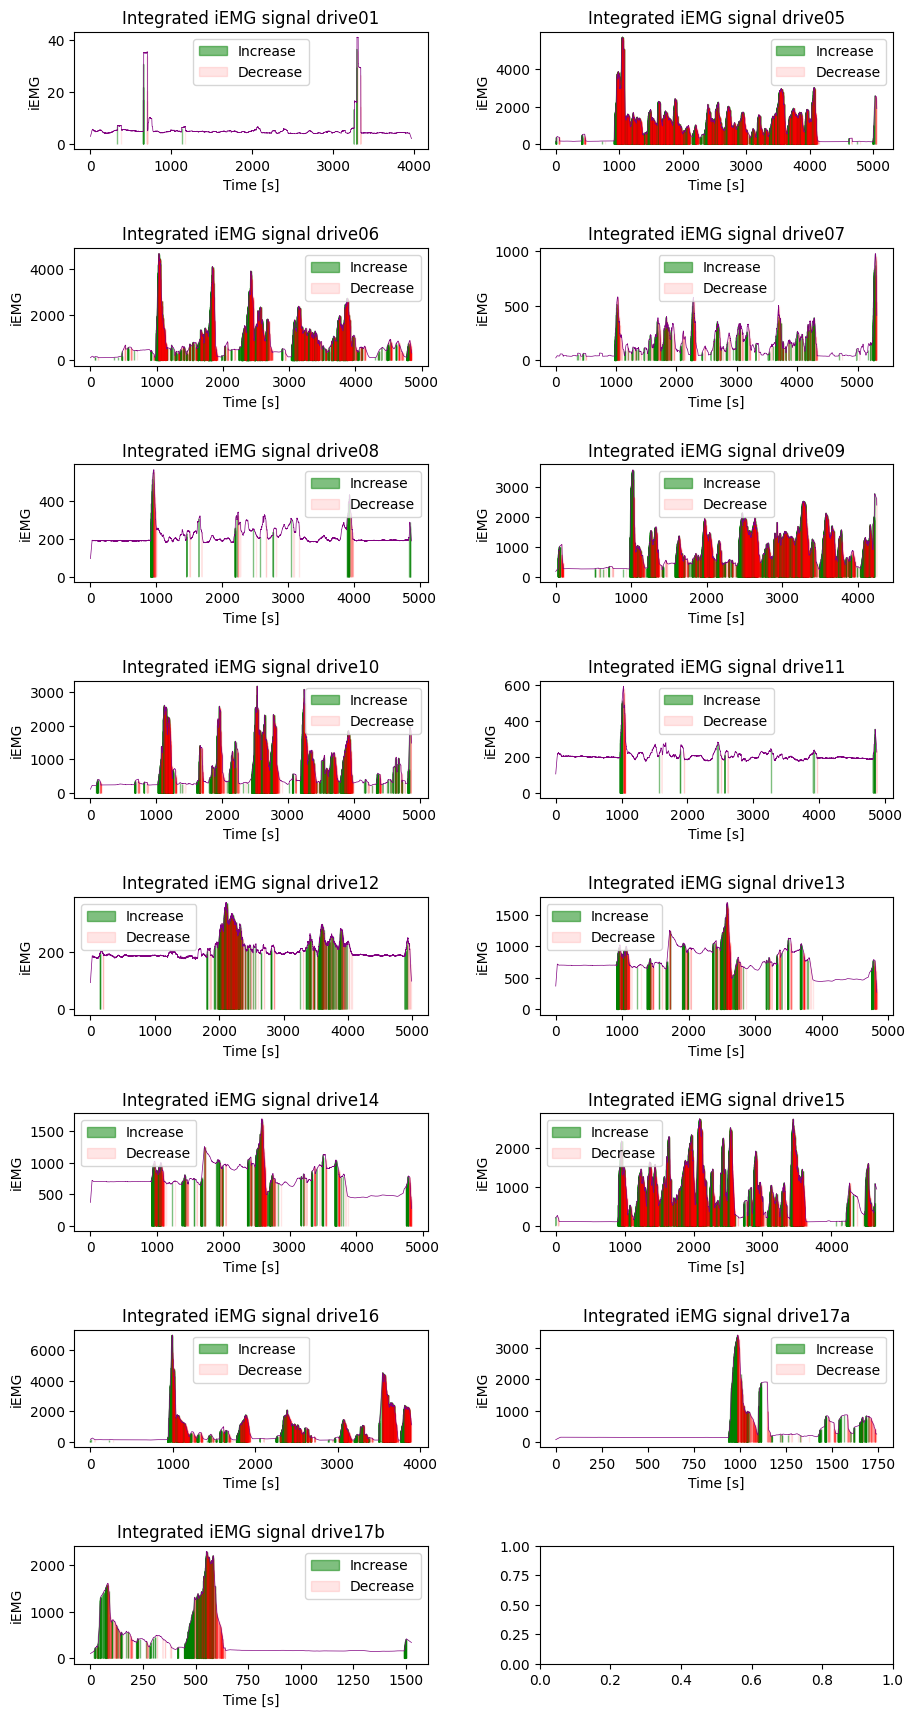

iEMG record drive01: 1.81 mV·s
iEMG record drive05: 300.14 mV·s
iEMG record drive06: 262.11 mV·s
iEMG record drive07: 44.75 mV·s
iEMG record drive08: 69.87 mV·s
iEMG record drive09: 279.33 mV·s
iEMG record drive10: 215.59 mV·s
iEMG record drive11: 67.69 mV·s
iEMG record drive12: 66.98 mV·s
iEMG record drive13: 240.79 mV·s
iEMG record drive14: 240.79 mV·s
iEMG record drive15: 228.28 mV·s
iEMG record drive16: 226.82 mV·s
iEMG record drive17a: 124.01 mV·s
iEMG record drive17b: 131.53 mV·s


In [22]:
signals, sinfos = load_train_data(do_sample=False, skip_no_emg=True)

values = []
threshold = 1.5

n_rows, n_cols = len(signals)//2+1, 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 18))
fig.tight_layout(pad=5.0)

for i, (signal, sinfo) in enumerate(zip(signals, sinfos)):
    rectified_signal = np.abs(signal)
    time = np.arange(len(signal)) / sinfo["fs"]
    values.append((np.sum(rectified_signal)) / (time[-1] / sinfo["fs"]))

    integrated_signal = np.convolve(rectified_signal, np.ones(int(sinfo["fs"])*50), mode="same")
    derivative = np.diff(integrated_signal)

    increasing = derivative > threshold
    decreasing = derivative < -threshold

    row_idx = i // n_cols
    col_idx = i % n_cols

    axs[row_idx, col_idx].plot(time, integrated_signal, color="purple", linewidth=0.5)
    axs[row_idx, col_idx].fill_between(
        time[1:], 
        integrated_signal[1:], 
        where=increasing, 
        color="green", 
        alpha=0.5, 
        label="Increase"
    )
    axs[row_idx, col_idx].fill_between(
        time[1:], 
        integrated_signal[1:], 
        where=decreasing, 
        color="red", 
        alpha=0.1, 
        label="Decrease"
    )
    
    axs[row_idx, col_idx].set_title(f"Integrated iEMG signal {sinfo['record_name']}")
    axs[row_idx, col_idx].set_xlabel("Time [s]")
    axs[row_idx, col_idx].set_ylabel("iEMG")
    axs[row_idx, col_idx].legend()

plt.show()

for idx in range(0, len(values)):
    print(f"iEMG record {sinfos[idx]['record_name']}: {values[idx]:.2f} mV·s")